## Walmart Weekly Sales Prediction

### Project Summary:
To Predict the Walmart's weekly sales across its 45 stores of different size and department is our major challenge. We are provided with historical sales data for 45 Walmart stores which are located in different regions. Each store contains many departments and we need to project the sales for each department in each store. To add to the challenge, selected holiday markdown events are also included in the dataset. These markdowns are known to affect sales, but ours challenge is to predict which departments are affected by these festival markdowns.

### 1. Background and Introduction

#### Background
Walmart is retail corporation that operates a chain of department stores and grocery stores in the United States.

#### The Problem
Identifying the impact of holidays and five markdown features on the weekly sales across different stores of walmart with different departments. Weekly sales can be predicted by monitoring a variety of different indicators. Example: Location of store, size of store, Holidays weeks, Promotional weeks, etc are  different factors which can affect the sales of the stores, which introduces more complexity to the regression process.

#### The goal of this project
The goal of project is to successfully predict. we are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments and we are tasked to predicte the department-wide sales for each store

#### Our Solution
We propose a solution which uses machine learning techniques like Multi linear regression, KNN, Decision Trees and
Random Forest to model and predict the sales. A well trained and generalized model will be able to predict the weekly sales across different department. Furthermore, we will also implement Hyperparameter tuning techniques like RandomizedSearchCV and GridSearchCV to optimizes the model for the metric that we choose.The models will be tested for their accuracy and robustness using evaluation metrics like MAE,  WMAE, MSE, RMSE and R-square.

### 2. Data Exploration and Visualization

#### Data Description
We are provided with the 4 data files as follow :
##### 1.stores.csv
This file contains anonymized information about the 45 stores, indicating the type and size of store.

##### 2.train.csv
This is the historical training data, which covers to 2010-02-05 to 2012-11-01. It contains the 5 features.

##### 3.test.csv
This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

##### 4.features.csv
This file contains additional data related to the store, department, and regional activity for the given dates. It contains the 12 features.


In [278]:
#Import required Libraries
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score, regressionSummary

#Handle warnings
import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

In [279]:
# Load the data from 4 files
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
features=pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

# The following features are present in train dataset
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [280]:
# We need to predict the weekly sales for following test dataset
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [281]:
# The following attributes which are related to stores and department are given in features dataset
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [282]:
# The features regarding stores are given in stores dataset
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Data cleaning and processing

Let's start by merging data from two of the datasets: train and features. They have a commom key - 'Store','Date','IsHoliday. Then again merge that data with stores with common key - 'Store' and load it in dataset - train_df.

Similarly, merge data from datasets: test and features. They have a commom key - 'Store','Date','IsHoliday. Then again merge that data with stores with common key - 'Store' and load it in dataset - test_df. 

In [283]:
train_df=pd.merge(pd.merge(train,features,on=['Store','Date','IsHoliday'],how='left'),stores,on=['Store'], how='left')
test_df=pd.merge(pd.merge(test,features,on=['Store','Date', 'IsHoliday'],how='left'),stores,on=['Store'], how='left')

In [284]:
# Rows and columns in dataset 
train_df.shape

(421570, 16)

In [285]:
# the datatype of the dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [286]:
# Rows and columns in dataset 
test_df.shape

(115064, 15)

In [287]:
# the datatype of the dataframe 
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday     115064 non-null  bool   
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     114915 non-null  float64
 7   MarkDown2     86437 non-null   float64
 8   MarkDown3     105235 non-null  float64
 9   MarkDown4     102176 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           76902 non-null   float64
 12  Unemployment  76902 non-null   float64
 13  Type          115064 non-null  object 
 14  Size          115064 non-null  int64  
dtypes: bool(1), float64(9), int64(3), object(2)
memory usage: 13.3+ MB


As we can notice that, the 'Date' field has string type. We can convert them to datetime in both the dataset.

And, The 'Date' field doesn't gives much information about the day, but to differentiate between holidays week with others week. It would be great to create 3 new fields -'Week', 'Month' & 'Year' for both the datasets.

In [288]:
#Change "Date" columntype from string to datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
train_df["Date"] = pd.to_datetime(train_df["Date"])

# Adding 3 new column to dataset - train_df
train_df['Year'] = pd.to_datetime(train_df['Date']).dt.year
train_df['Month'] = pd.to_datetime(train_df['Date']).dt.month
train_df['Week'] = pd.to_datetime(train_df['Date']).dt.week

# Adding 3 new column to dataset - test_df
test_df['Year'] = pd.to_datetime(test_df['Date']).dt.year
test_df['Month'] = pd.to_datetime(test_df['Date']).dt.month
test_df['Week'] = pd.to_datetime(test_df['Date']).dt.week

In [290]:
# Lets check the null values in training data
train_df_null_val = pd.concat([
    train_df.isnull().sum(axis = 0),
    (train_df.isnull().sum(axis = 0)/len(train_df))], axis=1)
train_df_null_val = train_df_null_val.rename(columns={0: 'No. of null values', 1: 'Percent of null values'})

train_df_null_val

,No. of null values,Percent of null values
Store,0,0.000000
Dept,0,0.000000
Date,0,0.000000
Weekly_Sales,0,0.000000
IsHoliday,0,0.000000
Temperature,0,0.000000
Fuel_Price,0,0.000000
MarkDown1,270889,0.642572
MarkDown2,310322,0.736110
MarkDown3,284479,0.674808


Only the features - Markdown 1 to 5 have missing data in train dataset and more than 60% values are null. So, if the correlations of these features with the target variable 'WeeklySales' are very low, then we can think about to drop them. 

In [291]:
# Lets check the null values in test data
test_df_null_val = pd.concat([
    test_df.isnull().sum(axis = 0),
    (test_df.isnull().sum(axis = 0)/len(test_df))], axis=1)
test_df_null_val = test_df_null_val.rename(columns={0: 'No. of null values', 1: 'Percent of null values'})

test_df_null_val

,No. of null values,Percent of null values
Store,0,0.000000
Dept,0,0.000000
Date,0,0.000000
IsHoliday,0,0.000000
Temperature,0,0.000000
Fuel_Price,0,0.000000
MarkDown1,149,0.001295
MarkDown2,28627,0.248792
MarkDown3,9829,0.085422
MarkDown4,12888,0.112007


As we can see that in test dataset, Columns - 'CPI' and 'Unemployment' are having null data, we will fill these null values with mean value of coulmn group by department.
And, the rest null values present in both the dataset will be filled by 0.

In [292]:
# Replace the null values
test_df['CPI'] = test_df.groupby(['Dept'])['CPI'].transform(lambda x:x.fillna(x.mean())) 
test_df['Unemployment'] = test_df.groupby(['Dept'])['Unemployment'].transform(lambda x:x.fillna(x.mean()))

# Fill the rest of the null values in both dataset with 0.
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [293]:
# No null values in Traing dataset
train_df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
dtype: int64

#### Encoding Categorical values
For Column - 'Type', we can assume that A > B > C in terms of Sales Median. So, change it as an ordinal variable and replace its values.
Similary for Column - 'IsHoliday' has two value True/ False in terms of Holiday. So, change it as an ordinal variable and replace its values.

above 2 Ordinal variables are defined as below:

In [294]:
# label encode of column - IsHoliday 
train_df['IsHoliday'] = train_df['IsHoliday'].apply(lambda x: 1 if x == True else 0)
test_df['IsHoliday'] = test_df['IsHoliday'].apply(lambda x: 1 if x == True else 0)

# label encode of column - Type 
train_df['Type'] = train_df['Type'] .apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_df['Type'] = test_df['Type'].apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

### Exploratory Analysis and Data visualization
We analyzed the distributions of some attributes to get an idea about the distribution of the data.

In [295]:
# Overview of  training data
train_df.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,2.410088,136727.915739,2010.968591,6.449510,25.826762
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328,0.796876,3.243217,14.151887
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,1.000000,34875.000000,2010.000000,1.000000,1.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,2.000000,93638.000000,2010.000000,4.000000,14.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,3.000000,140167.000000,2011.000000,6.000000,26.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,3.000000,202505.000000,2012.000000,9.000000,38.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,3.000000,219622.000000,2012.000000,12.000000,52.000000


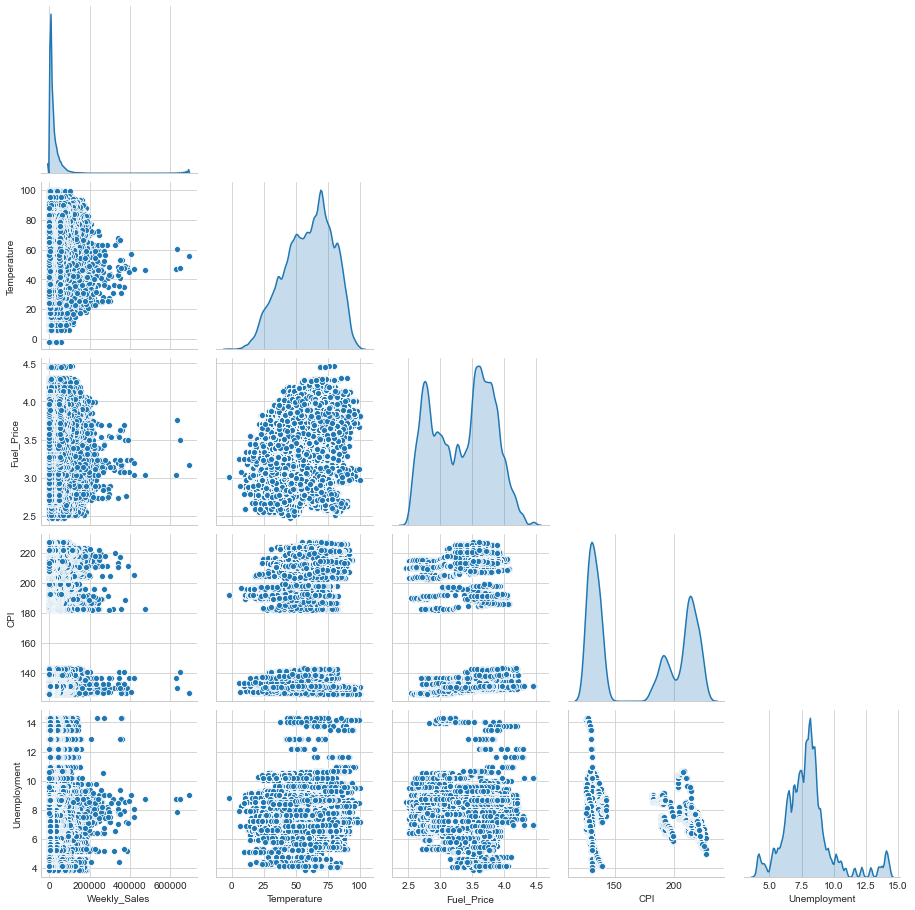

In [296]:
# Pairplot will helps us to understand data distribution of given coulmns with respect to Weekly sales
sns.pairplot(train_df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']],
             corner=True,diag_kind="kde")
plt.show()

From above graph, we can see that variables - Temperature, Fuel_Price, Unemployment, CPI all are skewed data  with respect to weekly sales and they does not display any particular relationship with the weekly sales.

#### Sales analysis

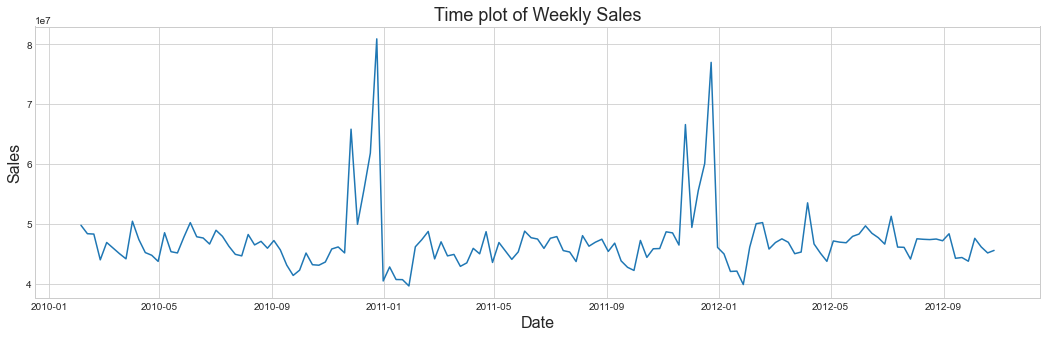

In [297]:
# Time plot of Weekly sales w.r.t date (with respect to holidays from 2010 to 2012)

df_average_sales_weekly = train_df.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()
df_average_sales = df_average_sales_weekly.sort_values("Weekly_Sales", ascending=False)
plt.figure(figsize=(18,5))
plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales)
plt.title('Time plot of Weekly Sales', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

Trend - no strong evidence of major trend on data
Seasonality - Strong seasonality in the training dataset, where the end of year seems like a popular time to buy our company's specific products. The theory is that this has to do with the holidays and people buy gifts for each other, which seems reasonable.
Random or Irregular movements - no major random events in datasets

Plotting the average sales on our dataset, we can see:

#### Using similar chart, to show mean and median of the weekly sales :

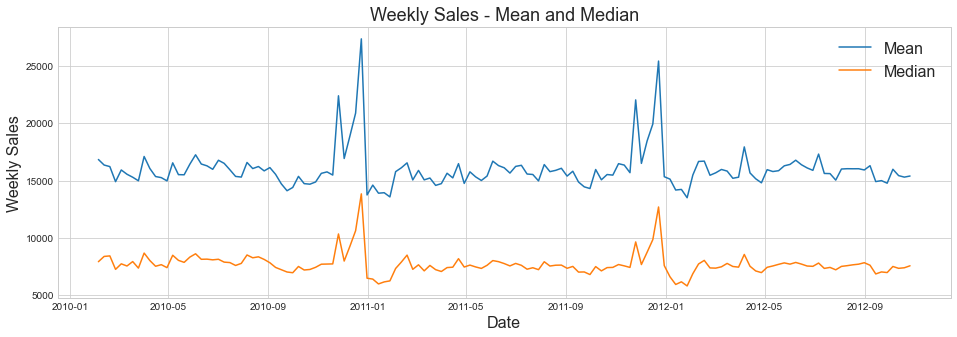

In [298]:
# time plot of mean and median of weekly sales

weekly_sales_mean = train_df['Weekly_Sales'].groupby(train_df['Date']).mean()
weekly_sales_median = train_df['Weekly_Sales'].groupby(train_df['Date']).median()
plt.figure(figsize=(16,5))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)

plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

We can notice that the mean and the median in above plot are very different, implementing that some stores/departments might sell much more than others.

#### Plot Average weekly Sales per Store 

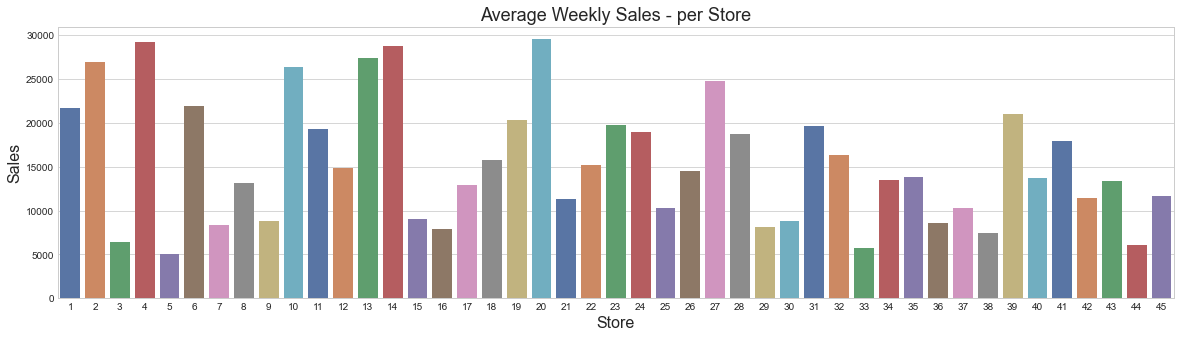

In [224]:
# Barplot of weekly sales w.r.t to different stores
weekly_sales = train_df['Weekly_Sales'].groupby(train_df['Store']).mean()
plt.figure(figsize=(20,5))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='deep')

plt.title('Average Weekly Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

We can notice that there are Sales difference between 45 Stores of Walmart

#### Plot Average weekly Sales per Department

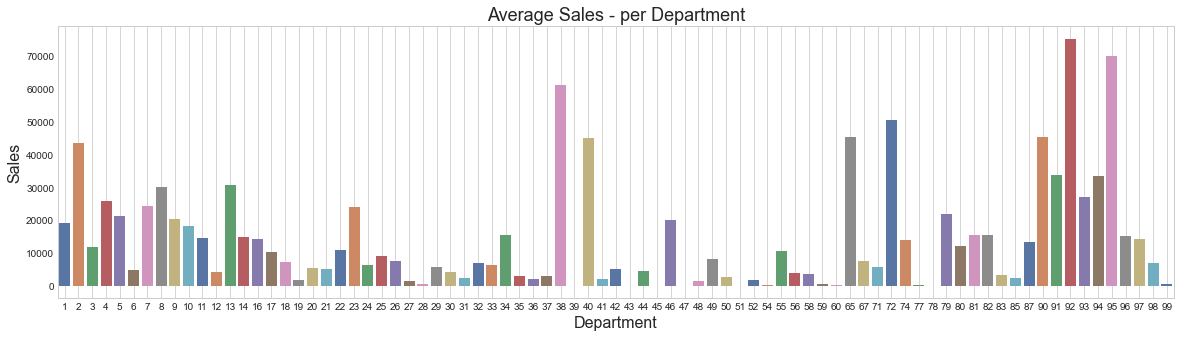

In [225]:
weekly_sales = train_df['Weekly_Sales'].groupby(train_df['Dept']).mean()
plt.figure(figsize=(20,5))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='deep')
plt.grid()
plt.title('Average Sales - per Department', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.show()

We can notice the Sales difference between the Departments also. Also some Departments are not in the training dataset.

##### Feature Correlation
Let's see the correlation between variables, using Pearson Correlation.
Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite

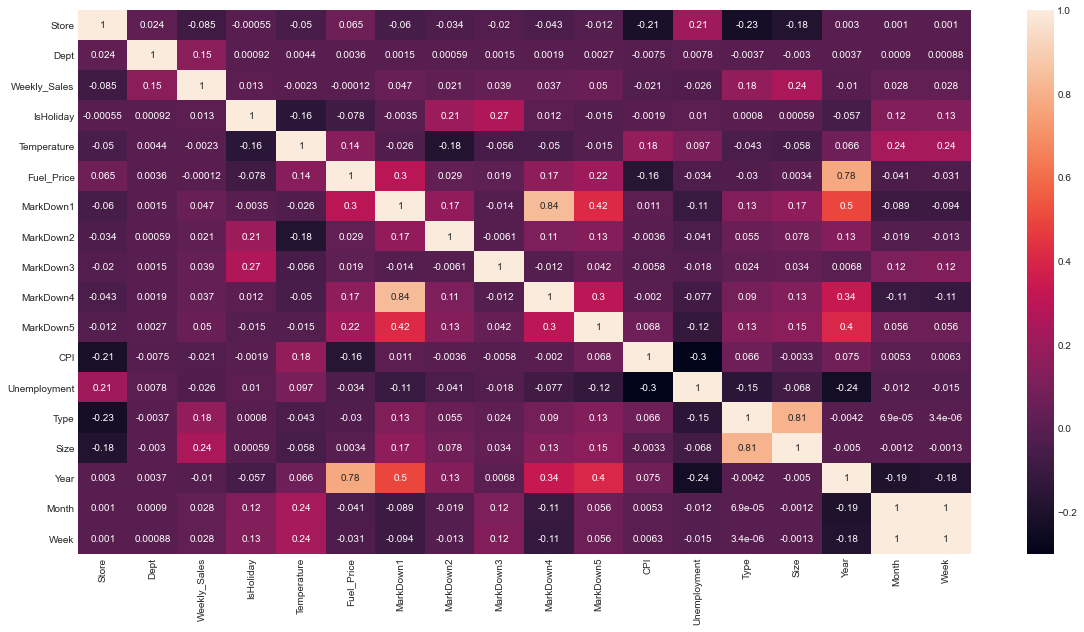

In [226]:
# Heatmap plot to understand Correlation between all features
plt.figure(figsize=(20,10))
sns.heatmap(train_df.corr(),annot=True)
plt.show()

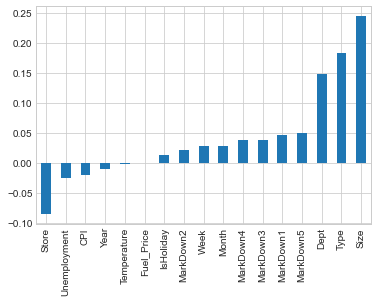

In [227]:
# Plotting bar graph for correlation values  
train_df.corr()['Weekly_Sales'].sort_values()[:-1].plot.bar()
plt.show()

According to above the correlation matrix by heatmap and barplot, we have below observations:

1.MarkDown1 to 5 has very weak correlation with Weekly Sales. All 5 features Markdown1 to 5 can be dropped as they will not play any role in the prediction of sales.

2.Month is strong correlated to Year. One of them can be dropped else they would carry similar information. 'Year' will not be dropped, because it differentiate same Weeks for Store/Department.

3.Features - Temperature, Fuel_Price, Unemployment, CPI have very low correlation with Sales as well as they are skewed too. So, we can dropped them.

In [228]:
train_df.drop(['Temperature', 'Fuel_Price', 'Unemployment', 'CPI','Month','Date'], axis=1, inplace=True)
train_df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5'], axis=1, inplace=True)

test_df.drop(['Temperature', 'Fuel_Price', 'Unemployment', 'CPI','Month','Date'], axis=1, inplace=True)
test_df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5'], axis=1, inplace=True)

##### Holiday Analysis 

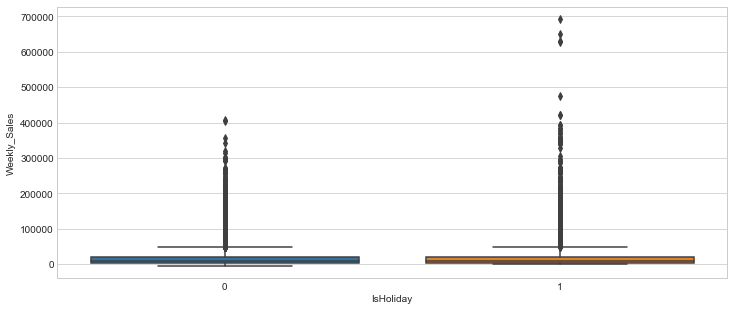

In [229]:
# Boxplot to understand the affect of holiday on weekly Sales
plt.figure(figsize=(12,5))
sns.boxplot(y=train_df['Weekly_Sales'],x=train_df['IsHoliday'])
plt.show()

We can see that its obvoius that Holidays weeks have more high sales than non-Holiday weeks.

In [230]:
# Function will calculate and return the weighted mean absolute error w.r.t Holidays.
# Since the weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks.

def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

### Train & Test Data for Data Modelling

Split the train_df dataset into train and test dataset. The train data will create the model and the test data will help to evaluate the created model respectively

In [231]:
# Prepare the train and test data
train_X = train_df.drop(["Weekly_Sales"], axis=1)
train_y = train_df["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3)

In [232]:
# Train dataframe 
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295099 entries, 110093 to 90686
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Store      295099 non-null  int64
 1   Dept       295099 non-null  int64
 2   IsHoliday  295099 non-null  int64
 3   Type       295099 non-null  int64
 4   Size       295099 non-null  int64
 5   Year       295099 non-null  int64
 6   Week       295099 non-null  int64
dtypes: int64(7)
memory usage: 18.0 MB


### 3. Data Mining Techniques and Implementation

#### 1. Multilinear Regression

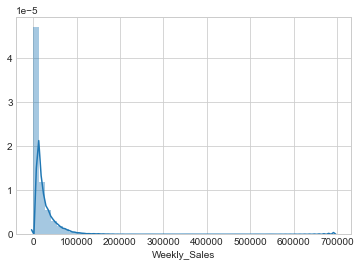

In [233]:
# Plotting distplot of log of weekly sales(to make its less skewed)
y1=y_train[np.isfinite(np.log(y_train))]
sns.distplot(y1,norm_hist=True)
plt.show()

The outcome is totally right-skewed even after log transformation.

In [234]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test) 

# print coefficients
print('intercept ',model.intercept_)
print(pd.DataFrame({'Predictor': X_train.columns, 'coefficient': model.coef_}))
print("\n")

# print performance measures
#regressionSummary(y_train, model.predict(X_train))
#regressionSummary(y_test, model.predict(X_test))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

score = r2_score(y_test, model.predict(X_test))
print("R^2:", score)

intercept  177322.20127121755
   Predictor  coefficient
0      Store   -88.046660
1       Dept   111.244361
2  IsHoliday   632.277872
3       Type -1897.911064
4       Size     0.104998
5       Year   -87.132227
6       Week    42.564228


MAE:  14569.154310544447
MSE:  475392011.8030852
RMSE:  21803.486230488124
R^2: 0.08415672713279299


In [235]:
#backward elimination
def train_model(variables):
    model = LinearRegression()
    model.fit(X_train[variables],y_train)
    return model

def score_model(model, variables):
    return AIC_score(y_train, model.predict(X_train[variables]), model)

best_model, best_variables = backward_elimination(X_train.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Store, Dept, IsHoliday, Type, Size, Year, Week
Start: score=6730132.03
Step: score=6730132.03, remove None
['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Year', 'Week']


In [236]:
regressionSummary(y_test, best_model.predict(X_test[best_variables]))


Regression statistics

               Mean Error (ME) : -51.8275
Root Mean Squared Error (RMSE) : 21803.4862
     Mean Absolute Error (MAE) : 14569.1543


In [237]:
best_pred=best_model.predict(X_test[best_variables])
print('adjusted r2 : ', adjusted_r2_score(y_test, best_pred, best_model))
print('WMAE: ',WMAE(X_test, y_test, y_pred))

adjusted r2 :  0.08410603323093968
WMAE:  14860.08


Based on the graph and the R^2 result in this part, it clearly shows that multilinear regression is not a good fit to our data.

#### 2. KNN Regressor

In [177]:
#Preprocessing – Scaling the features

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(X_train)
x_train_scaled = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(X_test)
x_test_scaled = pd.DataFrame(x_test_scaled)

In [178]:
#The error rate for different k values
rmse_val = [] #to store rmse values for different k
for K in range(10):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train_scaled, y_train)  #fit the model
    pred= model.predict(x_test_scaled) #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 22773.833737555567
RMSE value for k=  2 is: 17077.567449601567
RMSE value for k=  3 is: 15191.938507818915
RMSE value for k=  4 is: 15523.517581135826
RMSE value for k=  5 is: 16010.26785122133
RMSE value for k=  6 is: 16304.150728740238
RMSE value for k=  7 is: 16481.12283402409
RMSE value for k=  8 is: 16581.106045678833
RMSE value for k=  9 is: 16634.0626028687
RMSE value for k=  10 is: 16623.62495123976


In [179]:
#For K=3 with low RMSE is the best value for this case
knn = KNeighborsRegressor(n_neighbors = 3).fit(x_train_scaled, y_train) 
y_pred = knn.predict(x_test_scaled)

In [181]:
# Print out the MAE, MSE, RMSE & Weighted MAE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  8579.7805280789
MSE:  230794995.62535122
RMSE:  15191.938507818915
R^2: 0.5593515874475717


#### 3. Decision Tree Regressor

In [182]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [183]:
# Print out the MAE, MSE, RMSE & Weighted MAE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("WMAE: ",WMAE(X_test, y_test, y_pred)) #WMAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  1690.1542975860077
WMAE:  1901.73
MSE:  22418055.20801718
RMSE:  4734.770871754744
R^2: 0.9571980301688986


Above accuracy score raise the concern of overfitting of the given train data

#### 4. Random Forest Regressor

In [264]:
rf = RandomForestRegressor(n_estimators=75)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [265]:
# Print out the MAE, MSE, MSE & Weighted MAE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("WMAE: ",WMAE(X_test, y_test, y_pred)) #WMAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  1374.3453335979527
WMAE:  1568.99
MSE:  14755765.951377014
RMSE:  3841.323463518402
R^2: 0.9715729994466771


Lets perform the Hypertuning of parameter of Random forest using RandomizedSearchCV and GridSearchCV to improve the accuracy of prediction without overfitting the data.

In [45]:
#Initial guess for parameters
param_grid = {
'max_depth':[10,20,30],
'min_impurity_decrease':[0.001, 0.003, 0.005],
'min_samples_split':[2,3,4],
'n_estimators': [60,75,90],
'max_features' : [6,9,12]
}

In [162]:
# Using RandomizedSearchCV
rf=RandomForestRegressor()
rf_randomcv=RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, n_jobs=-1, verbose=2)
                               
### fit the randomized model
rf_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'max_features': [6, 9, 12],
                                        'min_impurity_decrease': [0.001, 0.003,
                                                                  0.005],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [60, 75, 90]},
                   verbose=2)

In [163]:
rf_randomcv.best_params_

{'n_estimators': 60,
 'min_samples_split': 3,
 'min_impurity_decrease': 0.001,
 'max_features': 6,
 'max_depth': 30}

In [187]:
best_random_grid=rf_randomcv.best_estimator_
y_pred=best_random_grid.predict(X_test)
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("WMAE: ",WMAE(X_test, y_test, y_pred)) #WMAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  1372.823098329921
WMAE:  1557.07
MSE:  12800073.145961931
RMSE:  3577.7189864440065
R^2: 0.9755612902392432


#### RandomForestRegressor tuned by GridSearchCV

In [189]:
#improved parameters using above parameters
param_grid2 = {
'max_depth':[25,30,35],
'min_impurity_decrease':[0,0.001,0.002],
'min_samples_split':[2,3,4],
'n_estimators': [50,60,70],
'max_features' : [6,9,10]
}

In [190]:
#### Fit the grid_search to the data
rf=RandomForestRegressor()
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid2,cv=3,n_jobs=-1,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 22.9min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [25, 30, 35], 'max_features': [6, 9, 10],
                         'min_impurity_decrease': [0, 0.001, 0.002],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 60, 70]},
             verbose=2)

In [191]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=35, max_features=6, min_impurity_decrease=0.001,
                      min_samples_split=3, n_estimators=70)

In [192]:
best_grid=grid_search.best_estimator_
best_grid

RandomForestRegressor(max_depth=35, max_features=6, min_impurity_decrease=0.001,
                      min_samples_split=3, n_estimators=70)

In [193]:
y_pred=best_grid.predict(X_test)
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("WMAE: ",WMAE(X_test, y_test, y_pred)) #WMAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  1369.0445545583389
WMAE:  1551.43
MSE:  12395739.353951525
RMSE:  3520.7583492695894
R^2: 0.9763332699050411


### 4. Performance Evaluation

After evaluating and comparing all the models we concluded that Random Forest regressor tunned with GridSearchCV performed the best on given dataset achieving a low WMAE of 1551.43 and R-square value of 0.9763. 

### 5. Predict

In [194]:
# Predict the Sales
final_predict = best_grid.predict(test_df)

In [195]:
final_predict

array([34937.18377857, 19392.36794524, 19413.46033333, ...,
         702.53375238,   780.04280952,   780.04280952])

In [196]:
# Store the final prediction in CSV file
submission = pd.read_csv('sampleSubmission.csv')
submission['Weekly_Sales'] = final_predict
submission.to_csv('final_predict.csv',index=False)
submission

,Id,Weekly_Sales
0,1_1_2012-11-02,34937.183779
1,1_1_2012-11-09,19392.367945
2,1_1_2012-11-16,19413.460333
3,1_1_2012-11-23,19905.226900
4,1_1_2012-11-30,24061.406310
...,...,...
115059,45_98_2013-06-28,727.091929
115060,45_98_2013-07-05,699.857752
115061,45_98_2013-07-12,702.533752
115062,45_98_2013-07-19,780.042810


#### 6.Summary
In this project, we test many different machine learning models to perform this prediction task. We train the model on given dataset. We conclude that a Hyperparameter tunned Random Forest Regressor performs the best in this task.